### **INITIALIZATION:**
- I use these three lines of code on top of my each notebooks because it will help to prevent any problems while reloading the same project. And the third line of code helps to make visualization within the notebook.

In [1]:
#@ INITIALIZATION:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

**DOWNLOADING THE DEPENDENCIES:**
- I have downloaded all the libraries and dependencies required for the project in one particular cell.

In [3]:
#@ DOWNLOADING THE LIBRARIES AND DEPENDENCIES:
# !pip install -U d2l
# !apt-get install p7zip-full

import os, collections, math
import shutil
import pandas as pd

import torch
import torchvision
from torch import nn
from d2l import torch as d2l

PROJECT_ROOT_DIR = "."
ID = "RECOG"
IMAGE_PATH = os.path.join(PROJECT_ROOT_DIR, "Images", ID)
if not os.path.isdir(IMAGE_PATH):
    os.makedirs(IMAGE_PATH)
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
  path = os.path.join(IMAGE_PATH, fig_id + "." + fig_extension)
  print("Saving Figure", fig_id)
  if tight_layout:
    plt.tight_layout()
  plt.savefig(path, format=fig_extension, dpi=resolution)

### **OBTAINING AND ORGANIZING THE DATASET:**
- I have used google colab for this project so the process of downloading and reading the data might be different in other platforms. I will use [**CIFAR-10 Object Recognition in Images**](https://www.kaggle.com/c/cifar-10) for this project. The dataset is divided into training set and test set. The training set contains 50,000 images. The images contains the categories such as planes, cars, birds, cats, deer, dogs, frogs, horses, boats and trucks.

In [4]:
#@ ORGANIZING THE DATASET: UNCOMMENT BELOW: 
# os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/Kaggle"
# %cd /content/drive/MyDrive/Kaggle
# !kaggle competitions download -c cifar-10

In [11]:
#@ OBTAINING THE DATASET: 
d2l.DATA_HUB["CIFAR10"] = (d2l.DATA_URL + "kaggle_cifar10_tiny.zip", 
                           '2068874e4b9a9f0fb07ebe0ad2b29754449ccacd')                  # Initializing the Dataset. 
demo = True                                                                             # Initialization. 
if demo: data_dir = d2l.download_extract("CIFAR10")                                     # Initialization. 
else: data_dir = "../Data/CIFAR10/"                                                     # Initializaiton. 

**ORGANIZING THE DATASET:**
- I will organize the datasets to facilitate model training and testing. 

In [12]:
#@ ORGANIZING THE DATASET: 
def read_csv_labels(fname):                                                             # Returning names to Labels. 
  with open(fname, "r") as f:
    lines = f.readlines()[1:]                                                           # Reading Lines. 
  tokens = [l.rstrip().split(",") for l in lines]
  return dict(((name, label) for name, label in tokens))
labels = read_csv_labels(os.path.join(data_dir, "trainLabels.csv"))                     # Implementation. 
print(f"Training Examples: {len(labels)}")                                              # Number of Training Examples. 
print(f"Classes: {len(set(labels.values()))}")                                          # Number of Classes. 

Training Examples: 1000
Classes: 10


In [13]:
#@ ORGANIZING THE DATASET: 
def copyfile(filename, target_dir):                                                      # Copying File into Target Directory. 
  os.makedirs(target_dir, exist_ok=True)
  shutil.copy(filename, target_dir)
#@ ORGANIZING THE DATASET: 
def reorg_train_valid(data_dir, labels, valid_ratio):
  n = collections.Counter(labels.values()).most_common()[-1][1]                          # Number of examples per class. 
  n_valid_per_label = max(1, math.floor(n * valid_ratio))
  label_count = {}
  for train_file in os.listdir(os.path.join(data_dir, "train")):
    label = labels[train_file.split(".")[0]]
    fname = os.path.join(data_dir, "train", train_file)
    copyfile(fname, os.path.join(data_dir, "train_valid_test", "train_valid", label))    # Copy to Train Valid. 
    if label not in label_count or label_count[label] < n_valid_per_label:
      copyfile(fname, os.path.join(data_dir, "train_valid_test", "valid", label))        # Copy to Valid. 
      label_count[label] = label_count.get(label, 0) + 1
    else: 
      copyfile(fname, os.path.join(data_dir, "train_valid_test", "train", label))        # Copy to Train. 
  return n_valid_per_label

- The reorg test function is used to organize the testing set to facilitate the reading during prediction. 

In [14]:
#@ ORGANIZING THE DATASET: 
def reorg_test(data_dir):                                                           # Initialization. 
  for test_file in os.listdir(os.path.join(data_dir, "test")):
    copyfile(os.path.join(data_dir, "test", test_file), 
             os.path.join(data_dir, "train_valid_test", "test", "unknown"))         # Implementation of Function. 

In [15]:
#@ OBTAINING AND ORGANIZING THE DATASET: 
def reorg_cifar10_data(data_dir, valid_ratio):                                      # Obtaining and Organizing the Dataset. 
  labels = read_csv_labels(os.path.join(data_dir, "trainLabels.csv"))               # Implementation of Function. 
  reorg_train_valid(data_dir, labels, valid_ratio)                                  # Implementation of Function. 
  reorg_test(data_dir)                                                              # Implementation of Function. 

In [16]:
#@ INITIALIZING THE PARAMETERS: 
batch_size = 4 if demo else 128                                                     # Initializing Batchsize. 
valid_ratio = 0.1                                                                   # Initialization. 
reorg_cifar10_data(data_dir, valid_ratio)                                           # Obtaining and Organizing the Dataset. 

### **IMAGE AUGMENTATION:**
- I will use image augmentation to cope with overfitting. The images are flipped at random and normalized. 

In [17]:
#@ IMPLEMENTATION OF IMAGE AUGMENTATION: TRAINING DATASET:  
transform_train = torchvision.transforms.Compose([                                   # Initialization. 
                  torchvision.transforms.Resize(40),                                 # Resizing both Height and Width.
                  torchvision.transforms.RandomResizedCrop(32, scale=(0.64, 1.0), 
                                                           ratio=(1.0, 1.0)),        # Cropping and Resizing. 
                  torchvision.transforms.RandomHorizontalFlip(),                     # Randomly Flipping Image. 
                  torchvision.transforms.ToTensor(),                                 # Converting into Tensors. 
                  torchvision.transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], 
                                                   std=[0.2023, 0.1994, 0.2010])])   # Normalization of RGB Channels. 
#@ IMPLEMENTATION OF IMAGE AUGMENTATION: TEST DATASET: 
transform_test = torchvision.transforms.Compose([
                 torchvision.transforms.ToTensor(),                                  # Converting into Tensors. 
                 torchvision.transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], 
                                                   std=[0.2023, 0.1994, 0.2010])])   # Normalization of RGB Channels. 

### **READING THE DATASET:**
- I will create the image folder dataset instance to read the organized dataset containing original image files where each example includes the image and label. 

In [18]:
#@ READING THE DATASET: 
train_ds, train_valid_ds = [torchvision.datasets.ImageFolder(
    os.path.join(data_dir, "train_valid_test", folder), 
    transform = transform_train) for folder in ["train", "train_valid"]]                    # Initializing Training Dataset. 
#@ READING THE DATASET: 
valid_ds, test_ds = [torchvision.datasets.ImageFolder(
    os.path.join(data_dir, "train_valid_test", folder), 
    transform = transform_test) for folder in ["valid", "test"]]                            # Initializing Test Dataset. 

In [19]:
#@ IMPLEMENTATION OF DATALOADER: 
train_iter, train_valid_iter = [torch.utils.data.DataLoader(
    dataset, batch_size, shuffle=True, drop_last=True) for dataset in (train_ds, 
                                                                       train_valid_ds)]      # Implementation of DataLoader. 
valid_iter = torch.utils.data.DataLoader(valid_ds, batch_size, shuffle=True, drop_last=True) # Implementation of DataLoader. 
test_iter = torch.utils.data.DataLoader(test_ds, batch_size, shuffle=True, drop_last=False)  # Implementation of DataLoader. 

### **DEFINING THE MODEL:**
- I will define ResNet18 model. I will perform xavier random initialization on the model before training begins. 

In [20]:
#@ DEFINING THE MODEL: 
def get_net():                                                              # Function for Initializing the Model. 
  num_classes = 10                                                          # Number of Classes. 
  net = d2l.resnet18(num_classes, 3)                                        # Initializing the RESNET Model. 
  return net

#@ DEFINING THE LOSS FUNCTION: 
loss = nn.CrossEntropyLoss(reduction="none")                                # Initializing Cross Entropy Loss Function. 

**DEFINING TRAINING FUNCTION:**
- I will define model training function train here. I will record the training time of each epoch which helps to compare costs of different models. 

In [23]:
#@ DEFINING TRAINING FUNCTIONS: 
def train(net, train_iter, valid_iter, num_epochs, lr, wd, devices, 
          lr_period, lr_decay):                                              # Defining Training Function. 
  trainer = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.9, 
                            weight_decay=wd)                                 # Initializing the SGD Optimizer. 
  scheduler = torch.optim.lr_scheduler.StepLR(trainer, lr_period, lr_decay)  # Initializing Learning Rate Scheduler. 
  num_batches, timer = len(train_iter), d2l.Timer()                          # Initializing the Parameters. 
  animator = d2l.Animator(xlabel="epoch", xlim=[1, num_epochs], 
                          legend=["train loss", "train acc", "valid acc"])   # Initializing the Animation. 
  net = nn.DataParallel(net, device_ids=devices).to(devices[0])              # Implementation of Parallelism on Model. 
  for epoch in range(num_epochs):
    net.train()                                                              # Initializing the Training Mode. 
    metric = d2l.Accumulator(3)                                              # Initializing the Accumulator. 
    for i, (features, labels) in enumerate(train_iter):
      timer.start()                                                          # Starting the Timer. 
      l, acc = d2l.train_batch_ch13(net, features, labels, loss, trainer, 
                                    devices)                                 # Initializing the Training. 
      metric.add(l, acc, labels.shape[0])                                    # Accumulating the Metrics. 
      timer.stop()                                                           # Stopping the Timer. 
      if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1: 
        animator.add(epoch + (i + 1) / num_batches, (
            metric[0] / metric[2], metric[1] / metric[2], None))             # Implementation of Animation. 
    if valid_iter is not None: 
      valid_acc = d2l.evaluate_accuracy_gpu(net, valid_iter)                 # Evaluating Validation Accuracy. 
      animator.add(epoch + 1, (None, None, valid_acc))                       # Implementation of Animation. 
    scheduler.step()                                                         # Optimization of the Model. 
  if valid_iter is not None: 
    print(f"Loss {metric[0] / metric[2]:.3f},"                               # Inspecting Loss. 
          f"Train acc {metric[1] / metric[2]:.3f},"                          # Inspecting Training Accuracy. 
          f"Valid acc {valid_acc:.3f}")                                      # Inspecting Validation Accuracy. 
  else: 
    print(f"Loss {metric[0] / metric[2]:.3f},"                               # Inspecting Loss. 
          f"Train acc {metric[1] / metric[2]:.3f}")                          # Inspecting Training Accuracy. 
  print(f"{metric[2]*num_epochs / timer.sum():.1f} examples/sec"
        f"on {str(devices)}")                                                # Inspecting Time Taken. 

### **TRAINING AND VALIDATING THE MODEL:**
- I will train and validate the model here. 

Loss nan,Train acc 0.102,Valid acc 0.100
283.7 examples/secon [device(type='cuda', index=0)]


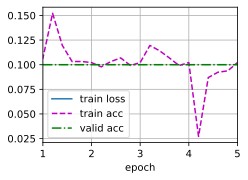

In [24]:
#@ TRAINING AND VALIDATING THE MODEL: 
devices, num_epochs, lr, wd = d2l.try_all_gpus(), 5, 0.1, 5e-4                # Initializing the Parameters. 
lr_period, lr_decay, net = 50, 0.1, get_net()                                 # Initializing the Neural Network Model. 
train(net, train_iter, valid_iter, num_epochs, lr, wd, devices, lr_period, 
      lr_decay)                                                               # Training the Model. 

**CLASSIFYING THE TESTING SET:**

Loss 2.520,Train acc 0.100
291.0 examples/secon [device(type='cuda', index=0)]


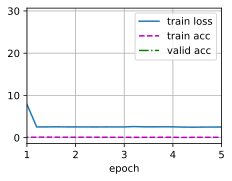

In [27]:
#@ CLASSIFYING THE TESTING SET: 
net, preds = get_net(), []                                                            # Initializing the Parameters. 
train(net, train_valid_iter, None, num_epochs, lr, wd, devices, lr_period, 
      lr_decay)                                                                       # Training the Model. 
for X, _ in test_iter:
  y_hat = net(X.to(devices[0]))
  preds.extend(y_hat.argmax(dim=1).type(torch.int32).cpu().numpy())
sorted_ids = list(range(1, len(test_ds) + 1))
sorted_ids.sort(key=lambda x: str(x))
df = pd.DataFrame({"id": sorted_ids, "label": preds})
df["label"] = df["label"].apply(lambda x: train_valid_ds.classes[x])
df.to_csv("result.csv", index=False)